### Imports

In [1]:
import warnings
warnings.filterwarnings('ignore')
import yfinance as yf
import numpy as np
import pandas as pd
import statsmodels.api as sm
from statsmodels.tsa.stattools import coint
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import zscore
from pykalman import KalmanFilter
# %pip install protobuf==3.20.3
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense, RNN
from tensorflow.keras import Input, Model
import time
from datetime import datetime, timedelta
from tensorflow.keras import layers, Model
import tensorflow as tf

Using TensorFlow backend.


### Hybrid LSTM Algorithm

In [2]:
class HybridLSTMCell(tf.keras.layers.Layer):
    def __init__(self, units, ratio=0.9, **kwargs):
        super(HybridLSTMCell, self).__init__(**kwargs)
        self.units = units
        self.ratio = ratio
        self.num_tanh = int(units * ratio)
        self.num_sigmoid = units - self.num_tanh
        self.state_size = [self.units, self.units]
        self.output_size = self.units
        
    def build(self, input_shape):
        self.kernel = self.add_weight(
            shape=(input_shape[-1] + self.units, 4 * self.units),
            initializer='glorot_uniform',
            name='kernel'
        )
        self.bias = self.add_weight(
            shape=(4 * self.units,),
            initializer='zeros',
            name='bias'
        )
        self.built = True
        
    def call(self, inputs, states):
        h_tm1, c_tm1 = states
        inputs_h = tf.concat([inputs, h_tm1], axis=-1)
        gates = tf.matmul(inputs_h, self.kernel) + self.bias
        
        # Split gates into input, forget, output, candidate
        i, f, o, c_hat = tf.split(gates, num_or_size_splits=4, axis=1)
        
        # Apply activations to gates
        i = tf.sigmoid(i)
        f = tf.sigmoid(f)
        o = tf.sigmoid(o)
        
        # Split candidate and apply hybrid activations
        c_hat_tanh = c_hat[:, :self.num_tanh]
        c_hat_sigmoid = c_hat[:, self.num_tanh:]
        c_hat_tanh = tf.tanh(c_hat_tanh)
        c_hat_sigmoid = tf.sigmoid(c_hat_sigmoid)
        c_hat = tf.concat([c_hat_tanh, c_hat_sigmoid], axis=1)
        
        # Update cell state
        c = f * c_tm1 + i * c_hat
        
        # Split cell state for hidden state
        c_tanh = c[:, :self.num_tanh]
        c_sigmoid = c[:, self.num_tanh:]
        
        # Compute hidden state with hybrid activations
        h_tanh = tf.tanh(c_tanh)
        h_sigmoid = tf.sigmoid(c_sigmoid)
        h = o * tf.concat([h_tanh, h_sigmoid], axis=1)
        
        return h, [h, c]

### Pos A. Cointegration + Econometrics + Kalman Filter Algorithm

In [3]:
def download_stock_data(symbols, start_date=None, end_date=None):
    if end_date is None:
        end_date = datetime.today()
    if start_date is None:
        start_date = end_date - timedelta(days=365)
    data = yf.download(symbols, start=start_date, end=end_date)['Close']
    return data.dropna()

def find_cointegrated_pairs(data, symbols):
    n = len(symbols)
    """score_matrix = np.zeros((n, n))
    pvalue_matrix = np.ones((n, n))
    beta_matrix = np.zeros((n, n))
    pairs = []
    for i in range(n):
        for j in range(i + 1, n):
            S1 = data[symbols[i]]
            S2 = data[symbols[j]]
            result = coint(S1, S2)
            model = sm.OLS(S1, sm.add_constant(S2)).fit()
            score = result[0]
            pvalue = result[1]
            score_matrix[i, j] = score
            pvalue_matrix[i, j] = pvalue
            beta_matrix[i, j] = model.params[1]
            if pvalue < 0.10:
                print(symbols[i], symbols[j], i, j, pvalue)
                pairs.append((symbols[i], symbols[j]))
    """
    score_matrix = 0
    pvalue_matrix = 0
    beta_matrix = 0
    
    S1 = data[symbols[0]]
    S2 = data[symbols[1]]
    result = coint(S1, S2)
    model = sm.OLS(S1, sm.add_constant(S2)).fit()
    score = result[0]
    pvalue = result[1]
    if pvalue < 0.10:
        print("COINTEGRATED!!!!")
        #pairs.append((symbols[i], symbols[j]))
    
    return score, pvalue, None, model.params[1]

def get_pos(zscore, S1, S2, hedge_ratios):
    # Initialize positions
    entry_z, exit_z = 1.5, 0.5
    long = zscore < -entry_z
    short = zscore > entry_z
    exit = abs(zscore) < exit_z
    indicator = 1
    if long[-1]:
        indicator = 1
    elif short[-1]:
        indicator = -1
    elif exit[-1]:
        print("EXIT!!!!!!!")
        indicator = 1
    else:
        print("DONT DO ANYTHING FOR TODAY!!!!!!!")
    print(f"Stock {S1}: {indicator * 1 * 100} ----- Stock {S2}: {indicator * -1 * int(hedge_ratios * 100)}")
    return 1
    
def kalman_filter(symbols):
    data = download_stock_data(symbols)
    S1 = symbols[0]
    S2 = symbols[1]
    # Drop missing data
    data = data.dropna()
    x = data[S1].values
    y = data[S2].values
    dates = data.index
    # Kalman Filter for dynamic hedge ratio
    kf = KalmanFilter(
        transition_matrices=np.eye(2),
        observation_matrices=np.vstack([x, np.ones_like(x)]).T[:, np.newaxis, :],
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.eye(2),
        observation_covariance=1.0,
        transition_covariance=0.01 * np.eye(2),
        em_vars=['transition_covariance', 'observation_covariance'] 
    )
    kf = kf.em(y, n_iter=10)
    state_means, _ = kf.filter(y)
    hedge_ratios = state_means[:, 0]
    intercepts = state_means[:, 1]
    # Compute spread and z-score
    spread = y - hedge_ratios * x - intercepts
    spread_series = pd.Series(spread, index=dates)
    rolling_mean = spread_series.rolling(window=20).mean()
    rolling_std = spread_series.rolling(window=20).std()
    zscore = (spread_series - rolling_mean) / rolling_std
    print(len(hedge_ratios))
    hedge_ratios = hedge_ratios[-1]
    get_pos(zscore, S1, S2, hedge_ratios)

### Pos B. LSTM RNN Model (Multi-feature OHLCV with Relative Strength Index (RSI))

In [4]:
def get_lstm_func(ticker="AAPL"):
    # === Date Setup for 1-Year Window ===
    end_date = datetime.today()
    start_date = end_date - timedelta(days=365)
    
    # === Data Collection ===
    df = yf.download(ticker, start=start_date.strftime("%Y-%m-%d"), end=end_date.strftime("%Y-%m-%d"))
    
    # === RSI Computation ===
    def compute_rsi(series, period=14):
        delta = series.diff()
        gain = delta.clip(lower=0)
        loss = -delta.clip(upper=0)
        avg_gain = gain.rolling(period).mean()
        avg_loss = loss.rolling(period).mean()
        rs = avg_gain / avg_loss
        return 100 - (100 / (1 + rs))
    
    df["RSI"] = compute_rsi(df["Close"])
    df = df.dropna()
    # === Feature Scaling ===
    features = ["Close", "Open", "High", "Low", "Volume", "RSI"]
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(df[features])
    target_scaler = MinMaxScaler()
    target = target_scaler.fit_transform(df[["Close"]])
    # === Sequence Preparation ===
    X, y = [], []
    seq_len = 20
    for i in range(seq_len, len(scaled)):
        X.append(scaled[i - seq_len:i])
        y.append(target[i])
    X, y = np.array(X), np.array(y)
    # === Train/Test Split ===
    test_size = int(len(X) * 0.2)
    X_train, y_train = X[:-test_size], y[:-test_size]
    # === Model Definition ===
    #model = Sequential()
    #model.add(LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    #model.add(LSTM(64))
    #model.add(Dense(1))
    #model.compile(optimizer="adam", loss="mse")
    inputs = Input(shape=(X_train.shape[1], X_train.shape[2]))
    x = RNN(HybridLSTMCell(64, ratio=0.9), return_sequences=True)(inputs)
    x = RNN(HybridLSTMCell(64, ratio=0.9))(x)
    outputs = Dense(1)(x)
    
    model = Model(inputs, outputs)
    model.compile(optimizer='adam', loss='mse')
    ########################
    # === Model Training ===
    model.fit(X_train, y_train, epochs=100, batch_size=5, verbose=0)
    # === t+1 Closing Price Prediction ===
    last_sequence = scaled[-seq_len:]
    last_sequence = last_sequence.reshape(1, seq_len, len(features))
    pred_scaled = model.predict(last_sequence)
    predicted_price = target_scaler.inverse_transform(pred_scaled)[0][0]
    return round(predicted_price, 2)

### Pos C. Transformer Neural Network Model

In [5]:
# === Transformer Model Definition ===
class TransformerModel(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, seq_length, num_transformer_blocks, dropout_rate=0.1):
        super(TransformerModel, self).__init__()
        self.embed_dim = embed_dim
        self.seq_length = seq_length
        self.num_transformer_blocks = num_transformer_blocks
        self.positional_encoding = self.positional_encoding(seq_length)
        self.transformer_blocks = [
            self.transformer_block(embed_dim, num_heads, ff_dim, dropout_rate)
            for _ in range(num_transformer_blocks)
        ]
        self.dropout_1 = layers.Dropout(dropout_rate)
        self.flatten = layers.Flatten()
        self.dense = layers.Dense(1)

    def call(self, inputs, training=True):
        word_emb = inputs
        pos_encoding_tiled = tf.tile(self.positional_encoding, [tf.shape(inputs)[0], 1, 1])
        word_emb += pos_encoding_tiled
        x = self.dropout_1(word_emb, training=training)
        for i in range(self.num_transformer_blocks):
            x = self.transformer_blocks[i](x, training=training)
        x = self.flatten(x)
        return self.dense(x)
        
    def transformer_block(self, embed_dim, num_heads, ff_dim, dropout_rate):
        inputs = layers.Input(shape=(None, embed_dim))
        attention = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim, dropout=dropout_rate)(inputs, inputs)
        attention = layers.Dropout(dropout_rate)(attention)
        attention = layers.LayerNormalization(epsilon=1e-6)(inputs + attention)
        outputs = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(attention)
        outputs = layers.Dropout(dropout_rate)(outputs)
        outputs = layers.Conv1D(filters=embed_dim, kernel_size=1)(outputs)
        outputs = layers.Dropout(dropout_rate)(outputs)
        outputs = layers.LayerNormalization(epsilon=1e-6)(attention + outputs)
        return Model(inputs=inputs, outputs=outputs)

    def positional_encoding(self, seq_length):
        pos = tf.cast(tf.range(seq_length)[:, tf.newaxis], dtype=tf.float32)
        i = tf.cast(tf.range(self.embed_dim)[tf.newaxis, :], dtype=tf.float32)
        angle_rads = pos / tf.pow(10000, 2 * (i // 2) / tf.cast(self.embed_dim, tf.float32))
        angle_rads = tf.where(tf.math.equal(i % 2, 0), tf.sin(angle_rads), tf.cos(angle_rads))
        return angle_rads[tf.newaxis, ...]


# === Modularized Transformer Prediction Function ===
def get_transformers_func(ticker="AAPL"):
    # === Data Collection (1-Year) ===
    end_date = datetime.today()
    start_date = end_date - timedelta(days=365)
    df = yf.download(ticker, start=start_date.strftime("%Y-%m-%d"), end=end_date.strftime("%Y-%m-%d"))
    stock_data = df.copy()
    # === Data Preparation ===
    closing_prices = stock_data["Close"].values.reshape(-1, 1)
    scaler = MinMaxScaler()
    scaled_prices = scaler.fit_transform(closing_prices)
    seq_length = 20
    X, y = [], []
    for i in range(len(scaled_prices) - seq_length):
        X.append(scaled_prices[i:i + seq_length])
        y.append(scaled_prices[i + seq_length])
    X, y = np.array(X), np.array(y)
    # === Model Hyperparameters ===
    embed_dim = 32
    num_heads = 2
    ff_dim = 32
    num_transformer_blocks = 2
    dropout_rate = 0.1
    learning_rate = 0.001
    batch_size = 64
    epochs = 100
    # === Model Initialisation ===
    model = TransformerModel(embed_dim, num_heads, ff_dim, seq_length, num_transformer_blocks, dropout_rate)
    loss_fn = tf.keras.losses.MeanSquaredError()
    optimizer = tf.keras.optimizers.Adam(learning_rate)

    @tf.function
    def train_step(inputs, targets):
        with tf.GradientTape() as tape:
            predictions = model(inputs, training=True)
            loss = loss_fn(targets, predictions)
        gradients = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))
        return loss

    # === Model Training ===
    num_batches = len(X) // batch_size
    for epoch in range(epochs):
        for i in range(num_batches):
            start_idx, end_idx = i * batch_size, (i + 1) * batch_size
            batch_X, batch_y = X[start_idx:end_idx], y[start_idx:end_idx]
            train_step(batch_X, batch_y)
    # === t+1 Closing Price Prediction ===
    last_seq = X[-1].reshape(1, seq_length, 1)
    pred_scaled = model(last_seq)
    predicted_price = scaler.inverse_transform(pred_scaled.numpy().reshape(-1, 1))[0][0]
    return round(predicted_price, 2)

### Pos B+C. Prediction DataFrame Builder

In [6]:
def build_prediction_df(tickers, model_func, n_days=30):
    final_df = pd.DataFrame(columns=tickers)
    for ticker in tickers:
        # Get 1 year of Price Data
        end_date = datetime.today()
        start_date = end_date - timedelta(days=365)
        df = yf.download(ticker, start=start_date.strftime("%Y-%m-%d"), end=end_date.strftime("%Y-%m-%d"))
        # Skip if Close Price data is missing
        if "Close" not in df.columns or df["Close"].dropna().empty:
            print(f"Skipping {ticker} due to missing 'Close' prices.")
            continue
        # Get last `n_days` actual prices
        recent_prices = df["Close"].dropna().tail(n_days).copy()
        # Ensure we have enough recent prices
        if len(recent_prices) < n_days:
            print(f"Skipping {ticker} due to insufficient data (<{n_days} rows).")
            continue
        # Make sure it's a datetime index
        recent_prices.index = pd.to_datetime(recent_prices.index)
        # Predict t+1 Closing Price
        predicted_price = model_func(ticker)
        # print(predicted_price)
        # Predict next date
        predicted_date = recent_prices.index[-1] + timedelta(days=1)
        # print(predicted_date)
        # Append to existing series
        recent_prices.loc[predicted_date] = float(predicted_price)
        # print(recent_prices)
        final_df[ticker] = recent_prices.sort_index()
        # print(final_df)
    if final_df.empty:
        raise ValueError("No valid Stock data was found for any Ticker.")
    final_df.index.name = "Date"
    return final_df

### Trading Positions as per Implemented Strategy 

In [7]:
def get_pos2(data, symbols):
    scores, pvalues, pairs, beta_matrix = find_cointegrated_pairs(data, symbols)
    S1 = symbols[0]
    S2 = symbols[1]
    hedge_ratio = beta_matrix
    spread = data[S1] - hedge_ratio * data[S2]
    z_scores = zscore(spread)
    get_pos(z_scores, S1, S2, hedge_ratio)
    
def main(s1,s2,s3): 
    print("----------POS A: KALMAN FILTER -----------------")
    kalman_filter(s1)   
    print("\n\n----------POS B: LSTM -----------------")
    data = build_prediction_df(s2, get_lstm_func)
    get_pos2(data, s2)
    print("\n\n----------POS C: TRANSFORMERS -----------------")
    data2 = build_prediction_df(s3, get_transformers_func)
    get_pos2(data2, s3) 

### Strat Test Run

In [8]:
s1 = ['ADBE', 'JPM'] # Position A: ADBE (Adobe Inc) - JPM (JPMorgan Chase & Co)
s2 = ['EWA', 'EWC'] # Position B: EWA (iShares MSCI Australia ETF) - EWC (iShares MSCI Canada ETF)
s3 = ['CRM','MSFT'] # Position C: CRM (Salesforce Inc) - MSFT (Microsoft Corp)
main(s1,s2,s3)

----------POS A: KALMAN FILTER -----------------
YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  2 of 2 completed


250
Stock ADBE: -100 ----- Stock JPM: 76


----------POS B: LSTM -----------------


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

Stock EWA: -100 ----- Stock EWC: 44


----------POS C: TRANSFORMERS -----------------



[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Stock CRM: -100 ----- Stock MSFT: -6


### Kalman Filter Backtesting

In [9]:
def kalman_filter(S1, S2):
    # Drop missing data
    x = S1.values
    y = S2.values
    dates = S1.index
    # Kalman Filter for dynamic hedge ratio
    kf = KalmanFilter(
        transition_matrices=np.eye(2),
        observation_matrices=np.vstack([x, np.ones_like(x)]).T[:, np.newaxis, :],
        initial_state_mean=np.zeros(2),
        initial_state_covariance=np.eye(2),
        observation_covariance=1.0,
        transition_covariance=0.01 * np.eye(2),
        em_vars=['transition_covariance', 'observation_covariance'] 
    )
    kf = kf.em(y, n_iter=10)
    state_means, _ = kf.filter(y)
    hedge_ratios = state_means[:, 0]
    intercepts = state_means[:, 1]
    # Compute spread and z-score
    spread = y - hedge_ratios * x - intercepts
    spread_series = pd.Series(spread, index=dates)
    rolling_mean = spread_series.rolling(window=20).mean()
    rolling_std = spread_series.rolling(window=20).std()
    zscore = (spread_series - rolling_mean) / rolling_std
    return zscore, hedge_ratios
    
def trading_strategy(zscore, hedge_ratios, data):
    ## Trading strategy
    entry_z, exit_z = 1.5, 0.5
    long = zscore < -entry_z
    short = zscore > entry_z
    exit = abs(zscore) < exit_z
    data["long"] = long
    data["short"] = short
    data["exit"] = exit
    data["trade"] = data.apply(
        lambda x: "long" if x["long"] 
        else "short" if x["short"] 
        else "exit" if x["exit"] 
        else None, 
        axis=1
    )
    data = data.drop(['long', 'short', 'exit'], axis=1)
    # Initialize new column to store position state
    position = []
    current_pos = None  # None = flat, 'long' or 'short'  
    for signal in data['trade']:
        if signal in ('long', 'short'):
            position.append(signal)
            current_pos = signal
        elif signal == 'exit':
            if current_pos is not None:
                position.append(None)
                current_pos = None
            else:
                position.append(None)
        elif signal == None:
            if current_pos is not None:
                position.append('hold')
            else:
                position.append(None)       
    data['position'] = position
    data = data.drop(['trade'], axis=1)
    data["hedge_ratio"] = hedge_ratios
    data["hedge_ratio"] = data.apply(lambda x: x["hedge_ratio"] if x["position"] is not None else 0, axis = 1)
    data["hedge_ratio"] = data.apply(lambda x: -1 * x["hedge_ratio"] if x["position"] is 'short' else x["hedge_ratio"], axis = 1)
    data["prev trade"] = data["hedge_ratio"].shift(1)
    data["S2 unit change"] = data["hedge_ratio"] - data["prev trade"]
    data["S1 unit change"] = data.apply(lambda x: 1 if x["position"] == "long" 
                                             else -1 if x["position"] == "short"
                                             else 0, axis = 1)
    data["prev S1 units"] = data["S1 unit change"].shift(1)
    data["S1 unit change"] = data["S1 unit change"] - data["prev S1 units"]
    data = data.drop(['prev S1 units', 'prev trade'], axis=1)
    data["net cash"] = -data["EWA"] * data["S1 unit change"] + data["EWC"] * data["S2 unit change"]  
    ### calculating pnL
    data['S1 position'] = data['S1 unit change'].cumsum()
    data['S2 position'] = data['hedge_ratio'].cumsum()  
    data['S1 price change'] = data['EWA'].diff()
    data['S2 price change'] = data['EWC'].diff()
    data['holding pnl'] = data['S1 position'].shift(1) * data['S1 price change'] + data['S2 position'].shift(1) * data['S2 price change']
    # Step 5: total pnl
    data['pnl'] = data['holding pnl'] + data["net cash"] 
    data['cumulative pnl'] = data['pnl'].cumsum()
    return data
    
def visualize_pnl(data):
    # Plot Cumulative PnL
    plt.figure(figsize=(12, 6))
    plt.plot(data['cumulative pnl'], label='Cumulative PnL', color='blue')
    # Filter trade points
    trade_points = data[data['position'].notna()]
    # Split into long and short
    long_trades = trade_points[trade_points['position'] == 'long']
    short_trades = trade_points[trade_points['position'] == 'short']
    # Plot long trades
    plt.scatter(long_trades.index, long_trades['cumulative pnl'], color='green', label='Long Entry', marker='^', s=70)
    # Plot short trades
    plt.scatter(short_trades.index, short_trades['cumulative pnl'], color='red', label='Short Entry', marker='v', s=70)   
    plt.xlabel('Time')
    plt.ylabel('PnL')
    plt.title('Cumulative PnL with Trade Markers')
    plt.legend()
    plt.grid(True)
    plt.show()
    # Plot net cash
    plt.figure(figsize=(12, 6))
    plt.plot(data['net cash'], label='Net Cash in Hand', color='purple')
    plt.xlabel('Time')
    plt.ylabel('Net Cash')
    plt.title('Net Cash in Hand')
    plt.legend()
    plt.grid(True)
    plt.show()

def run_backtest():
    # Example pair (can replace by any of the pairs)
    symbols = ['EWA', 'EWC']
    S1 = symbols[0]
    S2 = symbols[1]
    data = download_stock_data(symbols)
    zscore, hedge_ratios = kalman_filter(data[S1], data[S2])
    data = trading_strategy(zscore, hedge_ratios, data)
    visualize_pnl(data)

### Strat Backtest Run

[*********************100%***********************]  2 of 2 completed


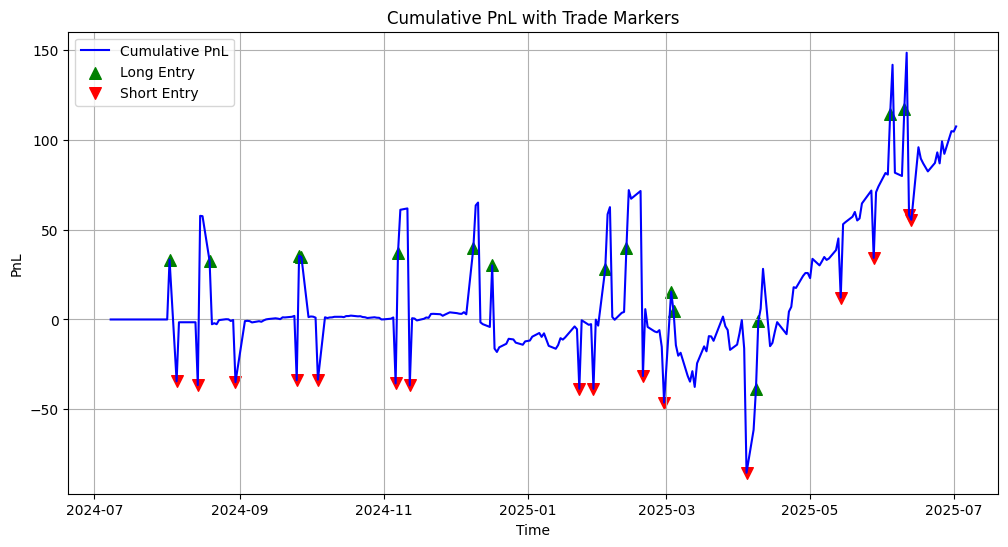

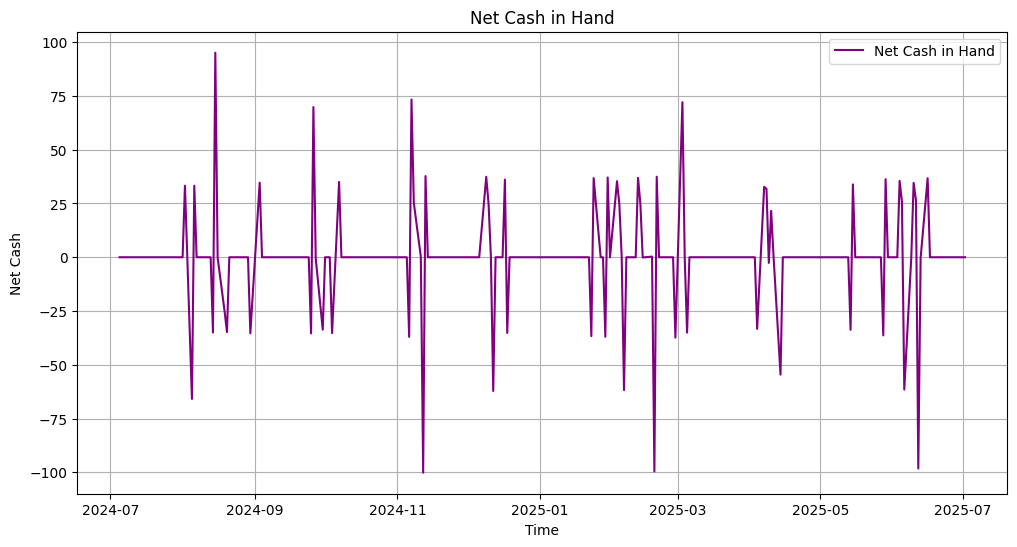

In [10]:
run_backtest()